In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

You should consider upgrading via the 'C:\ImageClassification\imageclassification\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
#importing dependencies
import tensorflow as tf
#interacting with the OS directly from within the Jupyter Notebook
import os
#removing the corrupted images from the dataset
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
#evaluating the performance of the model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [3]:
#limit the usage of GPU in order to avoid errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)    

In [5]:
#creating a variable to hold the path to our dir
data_dir = 'data'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
#looping trough each dir and subdir in 'data' dir and trough each image to remove corrupted pics
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
                print('Issue with image {}'.format(image_path))

In [9]:
#building data pipeline (classes, labels, pre-processing, resizing, shuffle, batch 32, etc.)
data = tf.keras.utils.image_dataset_from_directory('data')

Found 546 files belonging to 2 classes.


In [10]:
#allowing to loop trough data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
#accessing the data pipeline itself. Run twice to get another batch from the iterator.
batch = data_iterator.next()

In [12]:
#images as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
#Class 1 = Tea
#Class 0 = Ayran
batch[1]

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0])

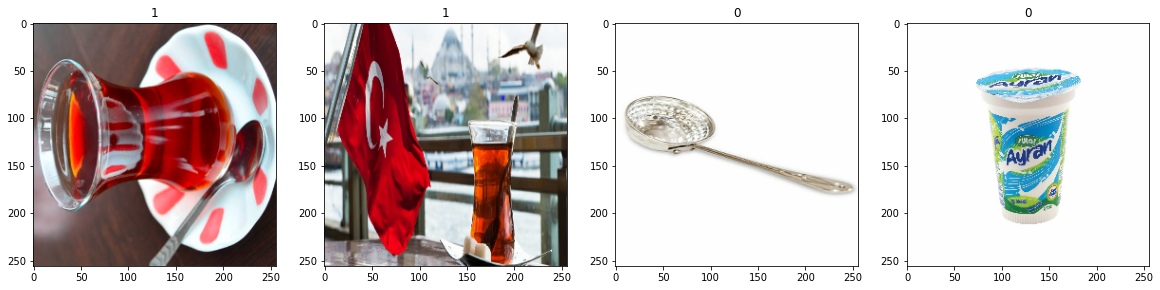

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
#Scaling. Minimizing the values to optimize faster. x - images, y - labels
data = data.map(lambda x,y: (x/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

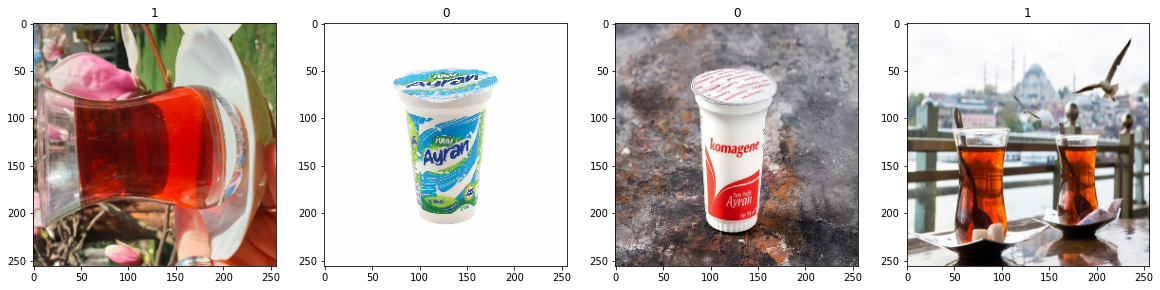

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [19]:
len(data)

18

In [20]:
#splitting data into train and validation sets
train_size = int(len(data)*.7) #train 70% 
val_size = int(len(data)*.2)+1 #validate 20%
test_size = int(len(data)*.1)+1

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [22]:
train_size+val_size+test_size

18

In [24]:
model = Sequential()

In [25]:
#adding convolutional layer and maxpooling layer by adding them sequentially
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
#compiling the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
#creating log dir
logdir='logs'

In [28]:
#creating a callback to be able to save the model at particular checkpoint or logging
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/11
12/12 [==============================] - 28s 2s/step - loss: 0.8693 - accuracy: 0.6797 - val_loss: 0.2086 - val_accuracy: 0.9688
Epoch 2/11
12/12 [==============================] - 22s 2s/step - loss: 0.1234 - accuracy: 0.9583 - val_loss: 0.0901 - val_accuracy: 0.9688
Epoch 3/11
12/12 [==============================] - 21s 2s/step - loss: 0.0695 - accuracy: 0.9688 - val_loss: 0.0855 - val_accuracy: 0.9688
Epoch 4/11
12/12 [==============================] - 22s 2s/step - loss: 0.0469 - accuracy: 0.9818 - val_loss: 0.0296 - val_accuracy: 0.9922
Epoch 5/11
12/12 [==============================] - 21s 2s/step - loss: 0.0426 - accuracy: 0.9870 - val_loss: 0.0879 - val_accuracy: 0.9688
Epoch 6/11
12/12 [==============================] - 21s 2s/step - loss: 0.0399 - accuracy: 0.9792 - val_loss: 0.0188 - val_accuracy: 0.9922
Epoch 7/11
12/12 [==============================] - 21s 2s/step - loss: 0.0183 - accuracy: 0.9896 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 8/11
12/12 [==

<function matplotlib.pyplot.show(close=None, block=None)>

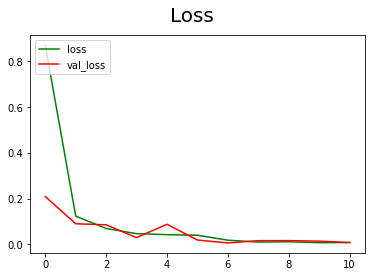

In [30]:
#visualizing the losses
fig=plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show

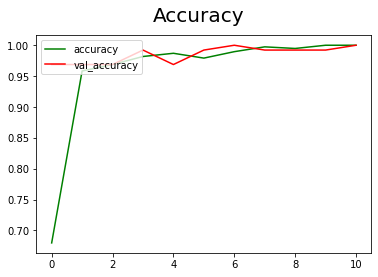

In [31]:
#visualizing the accuracy
fig=plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 85ms/step


In [35]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy}')

Precision:1.0, Recall:1.0, Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


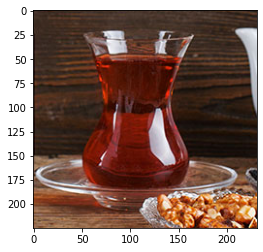

In [145]:
#testing the model using newcommer data
img = cv2.imread('tea_newcommer.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

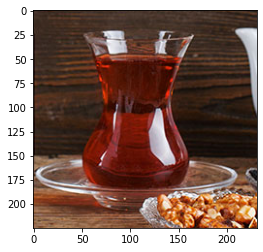

In [146]:
#resizing the image before passing trough neural network
resize = tf.image.resize(img, (256,256))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [147]:
resize.shape

TensorShape([256, 256, 3])

In [148]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [149]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 38ms/step


In [150]:
yhat

array([[0.87744975]], dtype=float32)

In [151]:
if yhat > 0.5: 
    print(f'Predicted class is Tea')
else:
    print(f'Predicted class is Ayran')

Predicted class is Tea
